In [56]:
import matplotlib.pyplot as plt
from AbundanceMatching import *
import numpy as np
import Corrfunc
from Corrfunc.theory import wp
from scipy.stats import multivariate_normal
from am_abundance_matching.galaxy_statistics import generate_wp

## Abundance Matching (SDSS)

In [57]:
data_path = '/u/ki/rmredd/data/'
# Luminosity function
lf_20 = np.loadtxt(data_path + 'lf/tinker/lf_jt_20.dat')
lf_19 = np.loadtxt(data_path + 'lf/tinker/lf_jt_19.dat')
lf_18 = np.loadtxt(data_path + 'lf/tinker/lf_jt_18.dat')
lf_18 = lf_18[lf_18[:,1]>0,:]

wp_path = '/u/ki/rmredd/data/corr_wp/tinker_sdss_wp/'
wp_20 = np.loadtxt(wp_path + 'wp_20.dat')
wp_20_cov_temp = np.loadtxt(wp_path + 'wp_covar_20.dat')
wp_20_cov = np.zeros((len(wp_20),len(wp_20)))
for wp_tup in wp_20_cov_temp:
    wp_20_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_20_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
r_cutoff = 15

# Halos from n body sim
halo_path = '/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/c125-1024/'
halos = np.load(halo_path + 'hlist_1.00000.npy')

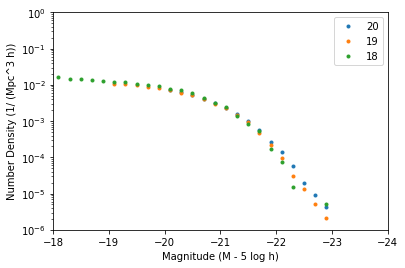

In [58]:
plt.plot(lf_20[:,0],lf_20[:,1],'.')
plt.plot(lf_19[:,0],lf_19[:,1],'.')
plt.plot(lf_18[:,0],lf_18[:,1],'.')
plt.ylim([1e-6,1])
plt.legend(['20','19','18'])
plt.yscale('log')
plt.xlabel('Magnitude (M - 5 log h)')
plt.ylabel('Number Density (1/ (Mpc^3 h))')
plt.xlim([-18,-24])
plt.show()

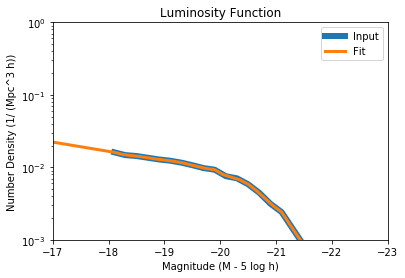

In [59]:
af = AbundanceFunction(lf_18[:,0], lf_18[:,1], (-25, -5))
plt.semilogy(lf_18[:,0], lf_18[:,1],lw=6)
x = np.linspace(-25, -10, 101)
plt.semilogy(x, af(x),lw=3)
plt.xlim([-17,-23])
plt.ylim([0.001,1])
plt.xlabel('Magnitude (M - 5 log h)')
plt.ylabel('Number Density (1/ (Mpc^3 h))')
plt.legend(['Input','Fit'])
plt.title('Luminosity Function')
plt.yscale('log')

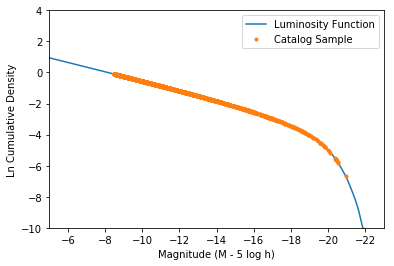

In [60]:
nd_halos = calc_number_densities(halos['vpeak'], 125)
catalog = af.match(nd_halos)
samp_rate = 1000
plt.ylim([-10,4])
plt.xlim([-5,-23])
plt.plot(af._x,af._nd_log)
plt.plot(catalog[::samp_rate],np.log(nd_halos)[::samp_rate],'.')
plt.ylabel('Ln Cumulative Density')
plt.xlabel('Magnitude (M - 5 log h)')
plt.legend(['Luminosity Function', 'Catalog Sample'])
plt.show()

In [81]:
box_size = 125.0
pimax = 40.0
nthreads = 4

# A luminosity cutoff to use for the correlation function. We will pick -20 to start
sub_catalog = catalog<-20.0
x = halos['x'][sub_catalog]
y = halos['y'][sub_catalog]
z = halos['z'][sub_catalog]

wp_20_cov=wp_20_cov[wp_20[:,0]<r_cutoff,:]
wp_20_cov=wp_20_cov[:,wp_20[:,0]<r_cutoff]
wp_20_var = np.diag(wp_20_cov)
wp_20 = wp_20[wp_20[:,0]<r_cutoff]

rbins = np.zeros(len(wp_20)+1)
rbins[1:-1] = 0.5*(wp_20[:-1,0]+wp_20[1:,0])
rbins[0] = 2*wp_20[0,0]-rbins[1]
rbins[-1] = 2*wp_20[-1,0]-rbins[-2]
wp_results = wp(box_size, pimax, nthreads, rbins, x, y, z, verbose=False, output_rpavg=True)
rp_avg = np.zeros(len(wp_results))
wp_binned = np.zeros(len(wp_results))
for i in range(len(wp_results)):
    rp_avg[i] = wp_results[i][2]
    wp_binned[i] = wp_results[i][3]

chi^2 is -69.231813


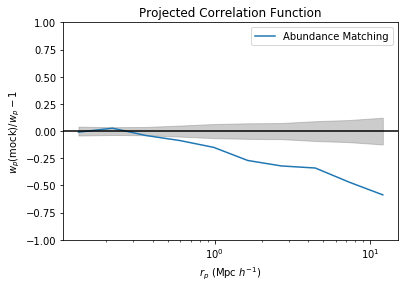

In [87]:
plt.plot(wp_20[:,0],wp_binned/wp_20[:,1]-1)
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('Projected Correlation Function')
plt.legend(['Abundance Matching'])
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')
print('chi^2 is %f'%(multivariate_normal.logpdf(wp_binned,wp_20[:,1],wp_20_cov)))

In [84]:
generate_wp(lf_18,halos,'vpeak',wp_20[:,0],box_size,-20.0)-wp_binned

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
wp_20[:,0]-rp_avg

array([-0.00144918, -0.0166265 , -0.02603543, -0.04461851, -0.07352776,
       -0.12343051, -0.21350316, -0.36409623, -0.58455193, -0.134172  ])

## Test Abundance Matching

In [2]:
# Load halo list file with information about halos in the box

rt_path = '/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/c125-1024/'
halos = np.load(rt_path + 'hlist_1.00000.npy')
# halos.dtype.names

In [3]:
# Load luminosity function 
def lum_function(M,phi_star,alpha,M_star):
    n_den = 0.4*np.log(10)*phi_star*np.power(10,0.4*(alpha+1)*(M_star-M))*np.exp(-10**(0.4*(M_star-M)))
    return n_den
M_sun = 4.65
M_star = -2.5*9.77 + M_sun
alpha = -0.93
phi_star = 1.16
M = np.linspace(-27, -18, 101)+M_sun
lf = np.zeros((len(M),2))
lf[:,0] = M
lf[:,1] = lum_function(M,phi_star,alpha,M_star)

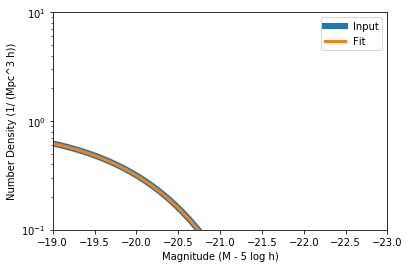

In [4]:
af = AbundanceFunction(lf[:,0], lf[:,1], (-25, -5))
plt.semilogy(lf[:,0], lf[:,1],lw=6)
x = np.linspace(-25, -10, 101)
plt.semilogy(x, af(x),lw=3)
plt.xlim([-19,-23])
plt.ylim([0.1,10])
plt.xlabel('Magnitude (M - 5 log h)')
plt.ylabel('Number Density (1/ (Mpc^3 h))')
plt.legend(['Input','Fit'])
plt.yscale('log')

In [5]:
# scatter = 0.04
# remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)
# x, nd = af.get_number_density_table()
# plt.plot(x, remainder/nd)
# plt.xlabel('Magnitude')
# plt.ylabel('Remainder')
# plt.show()
# plt.plot(x,nd)
# plt.plot(af._x_deconv[float(scatter*LF_SCATTER_MULT)],nd)
# plt.xlabel('Magnitude')
# plt.ylabel('Number Density')
# plt.legend(['Original','Deconvolved'])
# plt.yscale('log')
# plt.show()

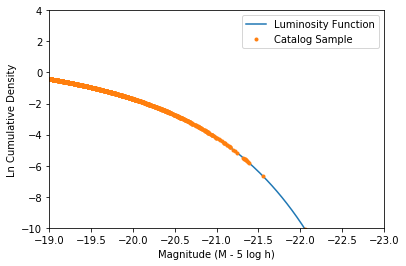

In [6]:
nd_halos = calc_number_densities(halos['vpeak'], 125)
catalog = af.match(nd_halos)
samp_rate = 1000
plt.ylim([-10,4])
plt.xlim([-19,-23])
plt.plot(af._x,af._nd_log)
plt.plot(catalog[::samp_rate],np.log(nd_halos)[::samp_rate],'.')
plt.ylabel('Ln Cumulative Density')
plt.xlabel('Magnitude (M - 5 log h)')
plt.legend(['Luminosity Function', 'Catalog Sample'])
plt.show()

## Test correlation function

In [21]:
box_size = 125.0
rmin = 0.1
rmax = 12
nbins = 20
pimax = 40.0
nthreads = 4

# A luminosity cutoff to use for the correlation function. We will pick -20 to start
sub_catalog = catalog>-20.0
x = halos['x'][sub_catalog]
y = halos['y'][sub_catalog]
z = halos['z'][sub_catalog]

rbins = np.logspace(np.log10(0.1), np.log10(rmax), nbins + 1)
wp_results = wp(box_size, pimax, nthreads, rbins, x, y, z, verbose=True, output_rpavg=True)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,3.  Time taken =   0.187 sec
countpairs_wp_double> gridlink seems inefficient. nmesh = (20, 20, 3); avg_np = 1.18e+03. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=125.000000 rpmax = 12.000000
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,3.  Time taken =   0.292 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =     3 mins   52 secs


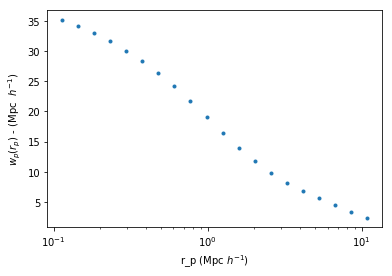

In [22]:
plt.plot(wp_results['rpavg'],wp_results['wp'],'.')
plt.ylabel('$w_p (r_p)$ - (Mpc  $h^{-1})$')
plt.xlabel('r_p (Mpc $ h^{-1}$)')
plt.xscale('log')